In [1]:
# Cell 1: Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
plt.style.use('ggplot')
sns.set_theme(style="whitegrid")

# Cell 2: Load the Data
# Note: Since the notebook is in notebooks/, we point to ../data/
data_dir = '../data'
sales = pd.read_csv(f'{data_dir}/sales.csv', parse_dates=['date'])
products = pd.read_csv(f'{data_dir}/products.csv')
stores = pd.read_csv(f'{data_dir}/stores.csv')
promotions = pd.read_csv(f'{data_dir}/promotions.csv', parse_dates=['date'])

print("Data loaded successfully.")

# Cell 3: Data Integration (Merging)
# We merge sales with products, stores, and promotions
df = sales.merge(products, on='product_id', how='left')
df = df.merge(stores, on='store_id', how='left')
df = df.merge(promotions, on='date', how='left')

# Sort by date to ensure proper time-series order
df = df.sort_values(by=['store_id', 'product_id', 'date']).reset_index(drop=True)

# Cell 4: Handling Stockouts (Crucial Rubric Requirement)
# The rubric asks to handle stockouts to avoid biasing demand signals.
# If a product was stocked out, the recorded sales are 0, but the *actual demand* was likely higher.
# For now, we will mark sales during stockouts as NaN so we can impute them later, 
# rather than training the model to predict 0 demand during those days.

df['actual_sales'] = df['sales_quantity']
df.loc[df['is_stockout'] == 1, 'actual_sales'] = np.nan

print(f"Merged Dataset Shape: {df.shape}")
display(df.head())
display(df.info())

Data loaded successfully.
Merged Dataset Shape: (73000, 13)


,date,store_id,product_id,sales_quantity,is_stockout,category,base_price,demand_type,store_type,location_tier,is_promo,discount_depth,actual_sales
0,2024-01-01,S001,P001,51,0,Groceries,78.35,Fast-Moving,Express,Tier 1,0,0.0,51.0
1,2024-01-02,S001,P001,46,0,Groceries,78.35,Fast-Moving,Express,Tier 1,0,0.0,46.0
2,2024-01-03,S001,P001,56,0,Groceries,78.35,Fast-Moving,Express,Tier 1,0,0.0,56.0
3,2024-01-04,S001,P001,48,0,Groceries,78.35,Fast-Moving,Express,Tier 1,0,0.0,48.0
4,2024-01-05,S001,P001,59,0,Groceries,78.35,Fast-Moving,Express,Tier 1,0,0.0,59.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73000 entries, 0 to 72999
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            73000 non-null  datetime64[ns]
 1   store_id        73000 non-null  object        
 2   product_id      73000 non-null  object        
 3   sales_quantity  73000 non-null  int64         
 4   is_stockout     73000 non-null  int64         
 5   category        73000 non-null  object        
 6   base_price      73000 non-null  float64       
 7   demand_type     73000 non-null  object        
 8   store_type      73000 non-null  object        
 9   location_tier   73000 non-null  object        
 10  is_promo        73000 non-null  int64         
 11  discount_depth  73000 non-null  float64       
 12  actual_sales    71621 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(3), object(6)
memory usage: 7.2+ MB


None

In [2]:
# Cell 5: Imputing Missing Data (Stockouts)
# We will use linear interpolation specific to each store-product combination 
# to estimate what the sales WOULD have been if the item was in stock.
import warnings
warnings.filterwarnings('ignore') # Suppress Pandas future warnings for cleaner output

df['imputed_sales'] = df.groupby(['store_id', 'product_id'])['actual_sales'].transform(
    lambda x: x.interpolate(method='linear', limit_direction='both')
)
# Fill any edge-case NaNs (e.g., if the very first day was a stockout)
df['imputed_sales'] = df['imputed_sales'].bfill().fillna(0)

print(f"Missing values in 'imputed_sales': {df['imputed_sales'].isna().sum()}")

Missing values in 'imputed_sales': 0


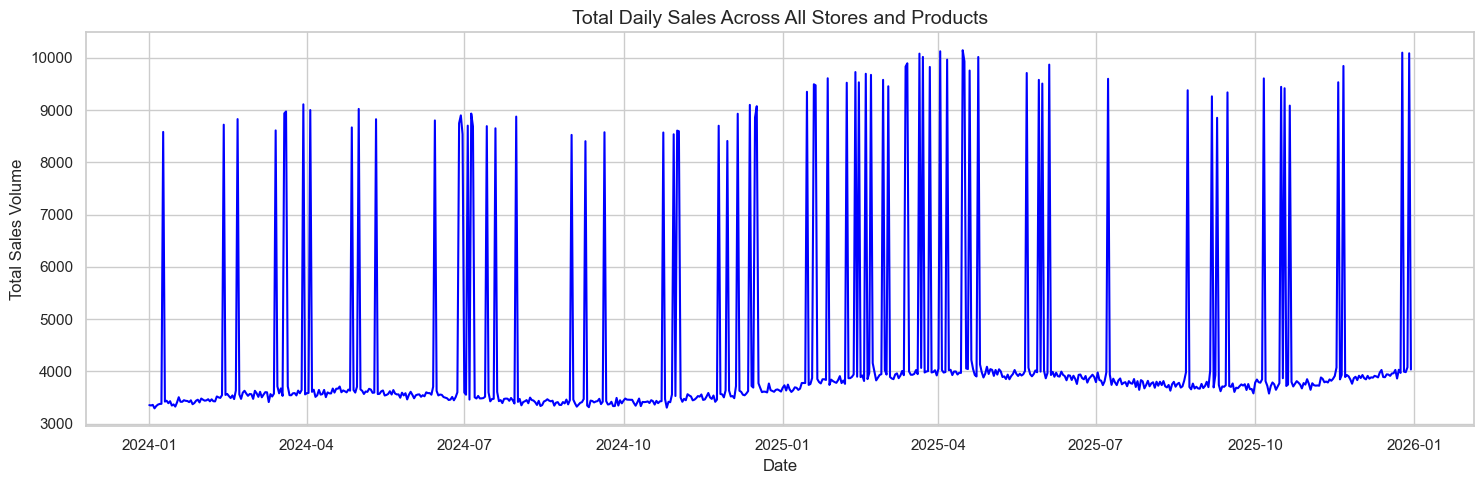

In [3]:
# Cell 6: Visualizing Demand at Different Aggregation Levels
# Let's look at the macro trend across the entire business.
daily_total = df.groupby('date')['imputed_sales'].sum().reset_index()

plt.figure(figsize=(15, 5))
sns.lineplot(data=daily_total, x='date', y='imputed_sales', color='blue')
plt.title('Total Daily Sales Across All Stores and Products', fontsize=14)
plt.ylabel('Total Sales Volume')
plt.xlabel('Date')
plt.tight_layout()
plt.show()

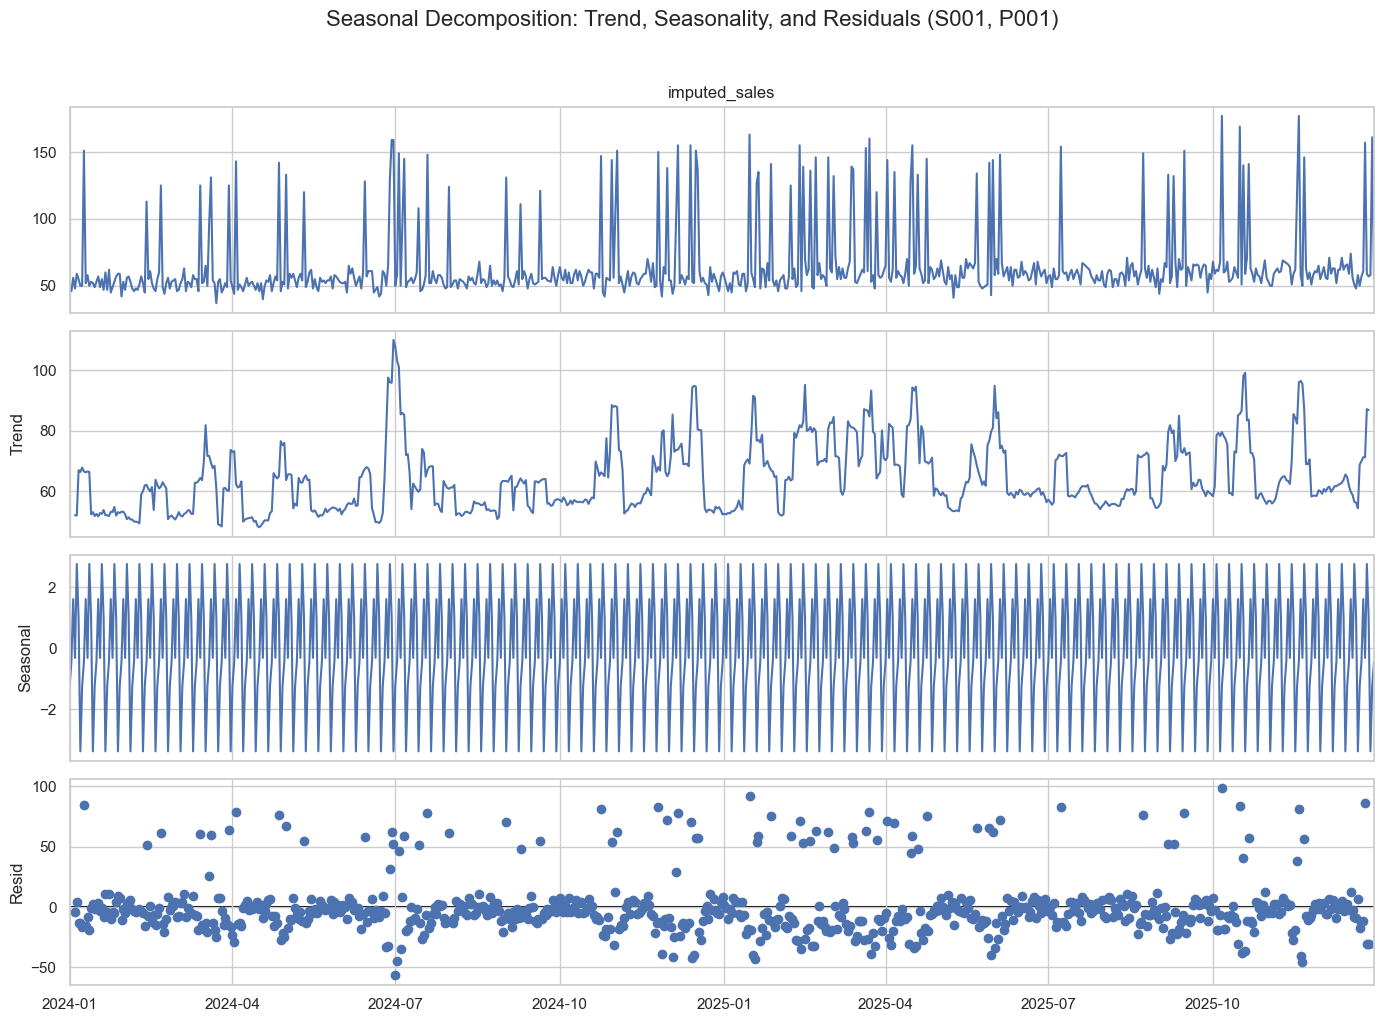

In [4]:
# Cell 7: Seasonal Decomposition (Crucial Rubric Requirement)
from statsmodels.tsa.seasonal import seasonal_decompose

# We will decompose a specific fast-moving product at a specific store to see clear patterns
# P001 from your screenshot is a Fast-Moving Grocery item. Let's analyze it!
sample_ts = df[(df['store_id'] == 'S001') & (df['product_id'] == 'P001')].set_index('date')['imputed_sales']

# Perform decomposition (Using a weekly period = 7 days)
decomposition = seasonal_decompose(sample_ts, model='additive', period=7)

fig = decomposition.plot()
fig.set_size_inches(14, 10)
fig.suptitle('Seasonal Decomposition: Trend, Seasonality, and Residuals (S001, P001)', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [5]:
# Cell 8: Feature Engineering
import sys
import os

# Add src to system path so we can import modules
sys.path.append(os.path.abspath('../src'))

from features import FeatureEngineer

# Initialize and run pipeline
fe = FeatureEngineer()
df_featured = fe.run_pipeline(df)

print(f"Dataset shape after feature engineering: {df_featured.shape}")
print("New Features created:")
print(df_featured.columns[13:]) # Print only the new columns
display(df_featured.head(3))

Dataset shape after feature engineering: (68875, 37)
New Features created:
Index(['imputed_sales', 'day_of_week', 'quarter', 'month', 'year',
       'day_of_year', 'is_weekend', 'is_holiday', 'lag_1', 'lag_7', 'lag_14',
       'lag_28', 'rolling_mean_7', 'rolling_std_7', 'rolling_mean_14',
       'rolling_std_14', 'rolling_mean_28', 'rolling_std_28',
       'store_id_encoded', 'product_id_encoded', 'category_encoded',
       'store_type_encoded', 'location_tier_encoded', 'demand_type_encoded'],
      dtype='object')


,date,store_id,product_id,sales_quantity,is_stockout,category,base_price,demand_type,store_type,location_tier,...,rolling_mean_14,rolling_std_14,rolling_mean_28,rolling_std_28,store_id_encoded,product_id_encoded,category_encoded,store_type_encoded,location_tier_encoded,demand_type_encoded
28,2024-01-29,S001,P001,59,0,Groceries,78.35,Fast-Moving,Express,Tier 1,...,53.000000,5.449065,56.178571,19.137037,0,0,2,0,0,0
29,2024-01-30,S001,P001,42,0,Groceries,78.35,Fast-Moving,Express,Tier 1,...,53.714286,5.539072,56.464286,19.116567,0,0,2,0,0,0
30,2024-01-31,S001,P001,53,0,Groceries,78.35,Fast-Moving,Express,Tier 1,...,52.928571,6.366551,56.321429,19.212368,0,0,2,0,0,0
